<a href="https://colab.research.google.com/github/bucky61/Data-Analysis-and-Machine-Learning/blob/main/Classifying_Review_Sentiment_with_Bag_of_Words_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Review Sentiment with Bag-of-Words Features

In natural language processing the **Bag-of-Words (BOW)** model turns a set of documents (a *corpus*) into fixed length numeric vectors that is ready to be processed by a classification algorithm. The first step involves choosing a fixed set of words (the *‘bag’* or *vocabulary*) which determines the length of the vector that will represent each document. Often, each entry of the vector is then filled with the count of the corresponding vocabulary word or some transformation of that vocabulary word (a *token*) and the count. There are lots of choices to make in the pre-processing step of choosing the ‘bag’. Different choices of vocabulary will result in different geometric representations of a document and can have effects on performance down the pipeline.

In this project a **logistic regression**, **neural network**, and **support vector machine (SVM)** will be used to classify product review sentiment. For each model/classifier, the effect of certain hyperparameters will be explored and optimized to maximize performance. The data for this project consists of 2,400 training examples consisting of reviews with a positive or negative review label from Amazon, IMDB, and Yelp.

## Import Packages and Data

In [ ]:
import numpy as np
import pandas as pd
import time
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

from warnings import filterwarnings
filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

What does the corpus look like?

In [ ]:
x_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/data_reviews/x_train.csv')
y_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/data_reviews/y_train.csv')
tr_text_list = x_train_df['text'].values.tolist()
y = y_train_df.values.ravel()

x_test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/data_reviews/x_test.csv')
tr_text_list_test = x_test_df['text'].values.tolist()

for text in tr_text_list[:10]:
    print(text)

## Preprocessing: Tokenize and Convert Text to Normalized Numeric Vectors

The preprocessing and construction of the BOW consists of three steps resulting in 17,402 features.

1.	Unify the case and remove whitespaces, punctuation, and numbers to reduce a review to a list of lower-case words. While case and punctuation can emphasize a sentiment, we can afford to lose these in a binary sentiment classification; a positive sentiment remains when changing ‘EXCELLENT SERVICE!!!!!’ to ‘excellent service’. Numbers may be relevant to classification since a rating system may be discussed in the review. However, random selections of reviews in this data set that contained numbers determined this was not often the case. Then remove a small set of twenty-five *stop words* consisting of common words like ‘a’, ‘the’, and ‘it’. This list was created as an alternative to the default set provided by scikit-learn. The default set is much larger and can remove enough words from a document to make the classification problem harder. For example, ‘not’ is in the list of stop words provided by scikit-learn, which is clearly an important word for determining positive and negative sentiment: ‘not good pizza’ and ‘good pizza’ would be reduced to the same vector if ‘not’ is a stop word. We follow what is suggested in scikit-learn documentation and create a smaller list of stop words that won’t remove common words like ‘not’ that could affect classification. The stop word list was inspired by a list from an ‘Introduction to Information Retrieval’ by Manning, Schutze, and Raghavan.

2.	Words are then *stemmed* or reduced to their root form. For example, ‘running’ and ‘runs’ would be reduced to the single token ‘run’. This is done because it reduces the number of features (the length of the resulting numeric vector) with probable small loss on classification performance; meaning should be preserved in the root regardless of tense or form. However, there are many methods to stem, and this is not a solved problem in Linguistics. Stemming was done using the PorterStemmer function from the Natural Language Processing toolkit. This is based on the Porter algorithm which uses suffix stripping to reduce a word to its root form and is one of the standards for stemming in English.

3.	Finally, the set of reviews are converted to a set of numeric vectors using TF-IDF features on both single tokens and consecutive tokens called bigrams. TF-IDF stands for *term frequency inverse document frequency*, which multiplies the number of times a vocabulary word occurs in a document by a ratio which captures how often that word occurs across all documents in the corpus. This has the effect of assigning a larger numerical value to a word that is rare across all documents but common in the one being analyzed. Conversely, a word that is common across all documents will reduce the inverse document frequency factor and will be assigned a smaller numerical value. The idea is that TF-IDF emphasizes words that are more representative of a particular document. The final vector is normalized to have unit length so there is no need to apply an additional preprocessing step of normalizing the data using scikit-learn MinMaxScaler or the like. A list of unigrams does not consider word order relationships so bigrams were included to capture sentiment and meaning in two-word phrases that may not be present in single words. The disadvantage is the number of features increases and training time for the models increases, and for this reason larger length n-grams were not considered. TF-IDF was chosen against an alternative creating a binary vector for each document indicating the presence of a token or bigram in a review. This alternative unfortunately ignores counts and global frequency and so was not chosen.




Below is the list of stop words that will be removed from the corpus. This is inspired by a list of stop words from an *‘Introduction to Information Retrieval’* by Manning, Schutze, and Raghavan.

In [ ]:
stop_words_Stanford = ['a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he', 'in', \
                       'is', 'it', 'of', 'on', 'that', 'the', 'to', 'was', 'were', 'will', 'with', 
                       'i', 'its', "it's", 'she', 'her', 'am', 'or', 'and', 'this', 'my', 'me', 'hers', 'his',
                       'we', 'had']

Now create a tokenizer which will first unify the case, remove whitespace and punctuation, and then remove stop the words. Additionaly, the function will stem the words using nltk *PorterStemmer* to reduce the number of features and combine similar forms of the same word into one token.

In [ ]:
def default_tokenizer(string):
    
    porter_stemmer = PorterStemmer()
    words_stem = set()
    words = re.sub(r"[^A-Za-z]", " ", string).lower().split()

    for i in range(len(words)):
        if words[i] not in stop_words_Stanford:
            words_stem.add(porter_stemmer.stem(words[i]))

    return list(words_stem)

Here is an example of what the tokenizer does!

In [ ]:
new_str = default_tokenizer(tr_text_list[0])
print(tr_text_list[0])
print(new_str)

Now we apply the tokenizer to the corpus to get the features.

In [ ]:
tf_vectorizer = TfidfVectorizer(tokenizer=default_tokenizer, ngram_range=(1,2))
x = tf_vectorizer.fit_transform(tr_text_list)
x = x.toarray()
x_col_names = tf_vectorizer.get_feature_names()
num_features = len(x[0])
print("Number of features: ", num_features, '\n')
print("Feature Names: ", x_col_names, '\n')
pd.DataFrame(x, columns=tf_vectorizer.get_feature_names())
print('Ratio of positive to negative reviews: ' + str(sum(y)/len(y)))

## Logistic Regression

After the BOW features were chosen, a logistic regression model was built to generate predictions for positive and negative reviews. To tune the various hyperparameters, **grid search** and **5-fold cross-validation** were used using scikit-learn GridSearchCV. This search samples from a given range of hyperparameters, performs five-fold cross-validation, and returns the model that has the highest average accuracy on the test fold. Grid search was done for the inverse regularization penalty and the regularization methods corresponding to lasso regression and ridge regression. The regularization penalty values were sampled across a log scale in order to capture the behavior of the model with both a small and large of amount of regularization. Likewise, lasso regression was explored because it is known to push features with small coefficients to zero which could inform feature selection and possibly improve performance on unseen test data.

In [ ]:
params = {'C':np.logspace(-5, 5, base=10, num=100), 
          'penalty':['l1', 'l2'], 
          'max_iter':range(100, 1000, 1),
          'solver': ['lbfgs', 'liblinear']}

logistic_reg = LogisticRegression()
random_search_max_iter = 100

start = time.time()
gscv = RandomizedSearchCV(logistic_reg, params, n_jobs=-1, n_iter=random_search_max_iter, return_train_score=True)
gscv.fit(x, y)
end = time.time()
print('Grid search took this many minutes: ' + str((end - start)/60))

opt_params = gscv.best_params_
opt_score = gscv.score(x, y)
print('Best parameters found:\n', opt_params)
print("Train accuracy: %.4f" % opt_score)

Look at the dataframe with the result of all the combinations explored by the random grid search to get a sense of how performance varied across combinations. We will summarize and plot some of these results below.

In [ ]:
cv_results_pd = pd.DataFrame(gscv.cv_results_)
cv_results_pd

To get a sense of how the performance changes across different hyperparameter values, plot average performance on training and test data for the regularization strength and maximum iterations

In [ ]:
for p in ['l1', 'l2']:
  max_iter_explored, c_explored, mean_test_score, mean_train_score, std_test_score, std_train_score = [], [], [], [], [], []
  # collect the cross-validation results from hyperparameter values explored
  for i in range(random_search_max_iter):
      curr_comb = cv_results_pd.iloc[i].to_dict()
      if curr_comb['param_penalty'] == p and curr_comb['param_solver'] == 'liblinear':
          max_iter_explored.append(curr_comb['param_max_iter'])
          c_explored.append(curr_comb['param_C'])
          mean_test_score.append(curr_comb['mean_test_score'])
          mean_train_score.append(curr_comb['mean_train_score'])
          std_test_score.append(curr_comb['std_test_score'])
          std_train_score.append(curr_comb['std_train_score'])

  # pull out unique values of penalty and sort to make a nice plot
  c_explored, i_explored = np.array(c_explored), np.array(max_iter_explored)
  mean_test_score = np.array(mean_test_score)
  mean_train_score = np.array(mean_train_score)
  std_test_score = np.array(std_test_score)
  std_train_score = np.array(std_train_score)

  c_explored, c_ind_uniq = np.unique(c_explored, return_index=True)
  i_explored, i_ind_uniq = np.unique(i_explored, return_index=True)
  c_mean_test_score, i_mean_test_score = mean_test_score[c_ind_uniq], mean_test_score[i_ind_uniq]
  c_mean_train_score,  i_mean_train_score = mean_train_score[c_ind_uniq], mean_train_score[i_ind_uniq]
  c_std_test_score, i_std_test_score = std_test_score[c_ind_uniq], std_test_score[i_ind_uniq]
  c_std_train_score, i_std_train_score = std_train_score[c_ind_uniq], std_train_score[i_ind_uniq]

  c_ind, i_ind = np.argsort(c_explored), np.argsort(i_explored)

  c_explored, i_explored = c_explored[c_ind], i_explored[i_ind]
  c_mean_test_score, i_mean_test_score = c_mean_test_score[c_ind], i_mean_test_score[i_ind]
  c_mean_train_score, i_mean_train_score = c_mean_train_score[c_ind], i_mean_train_score[i_ind]
  c_std_test_score, i_std_test_score = c_std_test_score[c_ind], i_std_test_score[i_ind]
  c_std_train_score, i_std_train_score = c_std_train_score[c_ind], i_std_train_score[i_ind]

  plt.figure()
  plt.errorbar(c_explored, c_mean_test_score, yerr=c_std_test_score)
  plt.errorbar(c_explored, c_mean_train_score, yerr=c_std_train_score)
  plt.xscale('log')
  plt.legend(['Test fold', 'Training fold'])
  if p == 'l1':
    plt.title('$l_1$' + ' Logistic Regression 5-Fold Accuracy vs. Inverse Penalty')
  else:
    plt.title('$l_2$' + ' Logistic Regression 5-Fold Accuracy vs. Inverse Penalty')
  plt.xlabel('Inverse Penalty Value')
  plt.ylabel('Mean CV Accuracy +/- STDV')

The figures above show the average cross validation accuracy for the training and test folds for both the $l_1$ and $l_2$ regularization penalty. For $l_2$ regularization, the blue curve indicates that the ideal range of inverse penalty values is $C = [1,100]$, where the mean test fold accuracy is maximized at $C = 9.1$ with $83.3\%$ accuracy (note, this will change slightly from iteration to iteration since this is a random grid search). The training fold accuracy at this maximum is $99.8\%$. In this range, the standard deviation is never larger than $2\%$ indicating there is small variation in the test fold accuracy, which bottoms out slightly above $80\%$ accuracy. Therefore, we have good reason to believe that the average 83.3% accuracy is a reliable indicator of test fold performance. Outside this range there is evidence of both underfitting and overfitting. Inverse penalty values above $C = 100$ have perfect average training fold accuracy but lower average test fold accuracy indicating that we are overfitting to the training data. Likewise, inverse penalty values below $C = 1$ have both lower average training fold accuracy and lower average test fold accuracy, indicating we are underfitting the model.

For $l_1$ regularization, we see two differences with $l_2$ regularization. The first difference is the dramatic change in both training and test fold performance across the range of inverse penalty values. There is a much larger swing in performance as $C$ increases for the $l_1$ penalty compared to the $l_2$ penalty. For the $l_1$ penalty, below approximately $C = .1$ both the average training and test fold accuracy is $50\%$. This could be because this parameter is an inverse penalty meaning smaller values correspond to more regularization and therefore too many features were ‘zeroed out’ by the $l_1$ penalty, resulting in a poor model. There are an equal number of positive and negative reviews in the training set which indicates that a highly regularized model is simply predicting the average sentiment/output (the average sentiment/output is $50\%$) of the reviews regardless text in the review. This is due to a model whose bias coefficient is the average sentiment/output, and all other coefficients are zero due to such high regularization. The second difference is the maximum average test fold accuracy is $82.4\%$ (versus $83.3\%$) with a standard deviation of $3\%$ (versus $2\%$). Because $l_1$ regularization gave lower average test fold accuracy and a slightly larger variation in test fold accuracy, $l_2$ regularization with $C = 9.1$ was chosen as the best set of hyperparameters for our logistic regression model.


## Neural Network

The next model used to classify the reviews is a neural network. Again, to tune the hyperparameters of the neural network both grid search in tandem with 5-fold cross-validation were used. The hyperparameters explored in the random grid search were regularization parameter strength, activation function, and size and number of layers in the neural network. The activation functions explored were the **ReLU** and **logistic** functions. There are tradeoffs between the two. Logistic activation functions can suffer from *saturation*, where many hidden neurons have large weights and small gradients exist across the network, resulting in an insensitive and possibly overfit model. ReLU is popular but can suffer from many *dead neurons* in the network whose output remains zero, limiting the flexibility of the network to fit to the data. Depending on the data, a neural network with enough layers and neurons is known to have the degrees of freedom to achieve 100% accuracy on training data, which should raise suspicion of overfitting. Because training time on the grid with cross-validation was outstandingly long for large layer numbers and sizes, only a small number of layers and sizes of the network were explored. Ideally, we would explore more layers and layer sizes but this proved computationally infeasible. Nonetheless, both one-layer and two-layer neural networks in the range of 50 to 200 neurons in a layer were explored.

In [ ]:
params = {
    'activation': ['logistic', 'relu'],
    'hidden_layer_sizes': [(50,), (100,), (200,), (50, 50), (200, 200)],
    'alpha': np.logspace(-5, 5, base=10, num=100),
    'solver': ['adam', 'sgd', 'lbfgs']}

network = MLPClassifier()
random_search_max_iter_nn = 100

start = time.time()
gscv_nn = RandomizedSearchCV(network, params, n_jobs=-1, n_iter=random_search_max_iter_nn, return_train_score=True)
gscv_nn.fit(x, y)
end = time.time()
print('Grid search took this many minutes: ' + str((end - start)/60))

opt_params_nn = gscv_nn.best_params_
opt_score_nn = gscv_nn.score(x, y)
print('Best parameters found:\n', opt_params_nn)
print("Accuracy: %.4f" % opt_score_nn)

NameError: ignored

In [ ]:
cv_results_pd = pd.DataFrame(gscv_nn.cv_results_)
cv_results_pd

NameError: ignored

[(50,), (100,), (200,), (50, 50), (200, 200)]


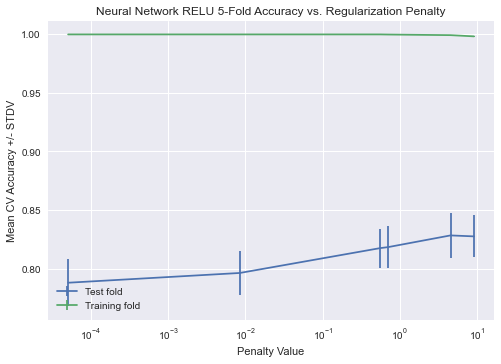

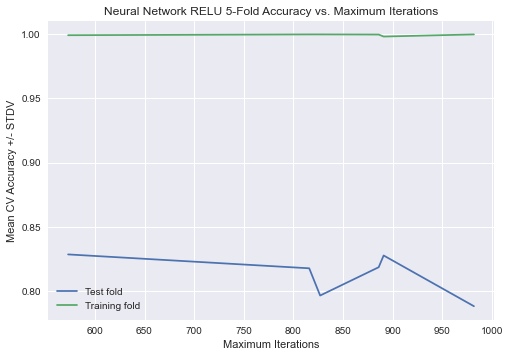

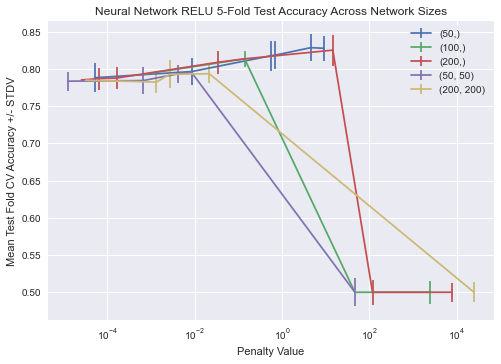

In [ ]:
c_explored = []
mean_test_score = []
mean_train_score = []
std_test_score = []
std_train_score = []

# collect the cross-validation results from hyperparameter values explored
for i in range(random_search_max_iter_nn):
    curr_comb = cv_results_pd.iloc[i].to_dict()
    if curr_comb['param_activation'] == 'relu' and curr_comb['param_hidden_layer_sizes'] == (50,):
        c_explored.append(curr_comb['param_alpha'])
        mean_test_score.append(curr_comb['mean_test_score'])
        mean_train_score.append(curr_comb['mean_train_score'])
        std_test_score.append(curr_comb['std_test_score'])
        std_train_score.append(curr_comb['std_train_score'])

# pull out unique values of penalty and sort to make a nice plot
c_explored = np.array(c_explored)
mean_test_score = np.array(mean_test_score)
mean_train_score = np.array(mean_train_score)
std_test_score = np.array(std_test_score)
std_train_score = np.array(std_train_score)

c_explored, c_ind_uniq = np.unique(c_explored, return_index=True)
c_mean_test_score = mean_test_score[c_ind_uniq]
c_mean_train_score = mean_train_score[c_ind_uniq]
c_std_test_score = std_test_score[c_ind_uniq]
c_std_train_score = std_train_score[c_ind_uniq]

c_ind = np.argsort(c_explored)

c_explored = c_explored[c_ind]
c_mean_test_score = c_mean_test_score[c_ind]
c_mean_train_score = c_mean_train_score[c_ind]
c_std_test_score = c_std_test_score[c_ind]
c_std_train_score = c_std_train_score[c_ind]

plt.figure()
plt.errorbar(c_explored, c_mean_test_score, yerr=c_std_test_score)
plt.errorbar(c_explored, c_mean_train_score, yerr=c_std_train_score)
plt.xscale('log')
plt.legend(['Test fold', 'Training fold'])
plt.title('Neural Network RELU 5-Fold Accuracy vs. Regularization Penalty')
plt.xlabel('Penalty Value')
plt.ylabel('Mean CV Accuracy +/- STDV')
plt.savefig('probs_test_nn/Neural Network RELU 5-Fold Accuracy vs. Regularization Penalty.png')

# now plot test fold for the various network layer sizes and lengths
plt.figure()
params_h = params['hidden_layer_sizes']
params_h[params_h==[]] = (50,)
params_temp = [i for i in params['hidden_layer_sizes'] if i not in [(100, 200), (100, 100), (200, 100)]]
print(params_temp)
for l in params_temp:
    c_explored = []
    mean_test_score = []
    std_test_score = []
    for i in range(random_search_max_iter_nn):
        curr_comb = cv_results_pd.iloc[i].to_dict()
        if curr_comb['param_activation'] == 'relu' and curr_comb['param_hidden_layer_sizes'] == l:
            c_explored.append(curr_comb['param_alpha'])
            mean_test_score.append(curr_comb['mean_test_score'])
            std_test_score.append(curr_comb['std_test_score'])
            
    c_explored, mean_test_score, std_test_score = np.array(c_explored), np.array(mean_test_score), np.array(std_test_score)
    c_ind = np.argsort(c_explored)
    c_explored = c_explored[c_ind]
    mean_test_score = mean_test_score[c_ind]
    c_std_test_score = std_test_score[c_ind]
    plt.errorbar(c_explored, mean_test_score, yerr=std_test_score)

plt.xscale('log')
plt.legend([str(i) for i in params_temp])
plt.title('Neural Network RELU 5-Fold Test Accuracy Across Network Sizes')
plt.xlabel('Penalty Value')
plt.ylabel('Mean Test Fold CV Accuracy +/- STDV')
plt.savefig('probs_test_nn/Neural Network RELU 5-Fold Test Accuracy Across Network Sizes.png')

In [ ]:
x_test = tf_vectorizer.transform(tr_text_list_test)

nn_opt = MLPClassifier(solver=opt_params_nn['solver'], activation=opt_params_nn['activation'], 
                       hidden_layer_sizes=opt_params_nn['hidden_layer_sizes'] , 
                       max_iter=opt_params_nn['max_iter'], alpha=opt_params_nn['alpha'])
nn_opt.fit(x, y)
probs1_test_nn = nn_opt.predict_proba(x_test)
np.savetxt('yproba1_test_nn.txt', probs1_test_nn[:, 1])

pd.DataFrame(x_test.toarray(), columns=tf_vectorizer.get_feature_names())

,abandon,abandon roll,abhor,abhor side,abil,abil call,abil particularli,abil pull,abil two,abl,...,z even,z pretti,zero,zero softwar,zero star,zero tast,zillion,zillion time,zombi,zombi fulci
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVM

Again use RandomGridSearchCV to select an optimal model

In [ ]:
params = {'C':np.logspace(-5, 5, base=10, num=100), 
          'gamma':np.logspace(-5, 5, base=10, num=100)}

svm = SVC()
random_search_max_iter_svm = 100

start = time.time()
gscv_svm = RandomizedSearchCV(svm, params, n_jobs=-1, n_iter=random_search_max_iter_svm, return_train_score=True)
gscv_svm.fit(x, y)
end = time.time()
print('Grid search took this many minutes: ' + str((end - start)/60))

opt_params_svm = gscv_svm.best_params_
opt_score_svm = gscv_svm.score(x, y)
print('Best parameters found:\n', opt_params_svm)
print("Train accuracy: %.4f" % opt_score_svm)

In [ ]:
params_c = {'C':np.logspace(-5, 5, base=10, num=11)}
params_g = {'gamma':np.logspace(-9, -5, base=10, num=5)}

svm = SVC()
search_max_iter_svm = 5

start = time.time()
gscv_svm = GridSearchCV(svm, params_c, n_jobs=-1, return_train_score=True)
gscv_svm.fit(x, y)
end = time.time()
print('Grid search took this many minutes: ' + str((end - start)/60))

opt_params_svm = gscv_svm.best_params_
opt_score_svm = gscv_svm.score(x, y)
print('Best parameters found:\n', opt_params_svm)
print("Train accuracy: %.4f" % opt_score_svm)

Grid search took this many minutes: 31.04525869290034
Best parameters found:
 {'C': 10.0}
Train accuracy: 1.0000


In [ ]:
cv_results_pd = pd.DataFrame(gscv_svm.cv_results_)
cv_results_pd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,100.320902,0.905517,36.627335,1.236427,0.00001,{'C': 1e-05},0.843750,0.647917,0.506250,0.514583,...,0.6075,0.128949,7,0.985417,0.935417,0.618750,0.588021,0.616146,0.748750,0.173881
1,98.008074,2.006748,36.179859,2.058223,0.0001,{'C': 0.0001},0.843750,0.647917,0.506250,0.514583,...,0.6075,0.128949,7,0.985417,0.935417,0.618750,0.588021,0.616146,0.748750,0.173881
2,96.326248,1.029931,36.670257,1.976744,0.001,{'C': 0.001},0.843750,0.647917,0.506250,0.514583,...,0.6075,0.128949,7,0.985417,0.935417,0.618750,0.588021,0.616146,0.748750,0.173881
3,93.491399,1.890340,37.862370,3.261910,0.01,{'C': 0.01},0.843750,0.647917,0.506250,0.514583,...,0.6075,0.128949,7,0.985417,0.935417,0.618750,0.588021,0.616146,0.748750,0.173881
4,91.978031,1.936037,36.911839,2.701145,0.1,{'C': 0.1},0.843750,0.647917,0.506250,0.514583,...,0.6075,0.128949,7,0.985417,0.935417,0.618750,0.588021,0.616146,0.748750,0.173881
5,91.605212,2.064517,36.156921,2.251774,1.0,{'C': 1.0},0.845833,0.827083,0.770833,0.816667,...,0.8200,0.026569,6,0.998958,0.998437,0.998437,0.998958,0.999479,0.998854,0.000390
6,88.670780,2.658817,35.013686,2.914485,10.0,{'C': 10.0},0.847917,0.825000,0.795833,0.806250,...,0.8225,0.019248,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,89.418786,3.068885,35.599748,1.103945,100.0,{'C': 100.0},0.847917,0.825000,0.795833,0.806250,...,0.8225,0.019248,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,87.661831,2.445614,35.956821,4.736381,1000.0,{'C': 1000.0},0.847917,0.825000,0.795833,0.806250,...,0.8225,0.019248,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,86.289666,4.783125,31.806769,0.755841,10000.0,{'C': 10000.0},0.847917,0.825000,0.795833,0.806250,...,0.8225,0.019248,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


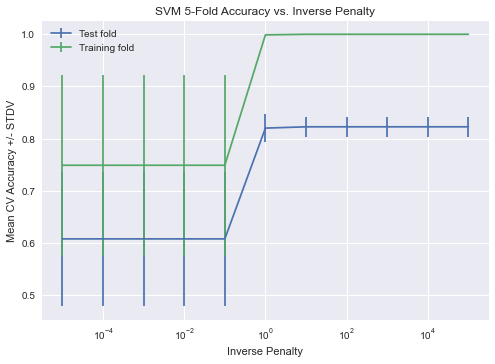

In [ ]:
gamma_explored = []
mean_test_score = []
mean_train_score = []
std_test_score = []
std_train_score = []
search_max_iter_svm = 11

# collect the cross-validation results from hyperparameter values explored
for i in range(search_max_iter_svm):
    curr_comb = cv_results_pd.iloc[i].to_dict()
    gamma_explored.append(curr_comb['param_C'])
    mean_test_score.append(curr_comb['mean_test_score'])
    mean_train_score.append(curr_comb['mean_train_score'])
    std_test_score.append(curr_comb['std_test_score'])
    std_train_score.append(curr_comb['std_train_score'])

# pull out unique values of penalty and sort to make a nice plot
i_explored = np.array(gamma_explored)
mean_test_score = np.array(mean_test_score)
mean_train_score = np.array(mean_train_score)
std_test_score = np.array(std_test_score)
std_train_score = np.array(std_train_score)

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(np.log10(c_explored), np.log10(i_explored), mean_test_score)

# plt.show()

i_explored, i_ind_uniq = np.unique(i_explored, return_index=True)
i_mean_test_score = mean_test_score[i_ind_uniq]
i_mean_train_score = mean_train_score[i_ind_uniq]
i_std_test_score = std_test_score[i_ind_uniq]
i_std_train_score = std_train_score[i_ind_uniq]

i_ind = np.argsort(i_explored)

i_explored = i_explored[i_ind]
i_mean_test_score = i_mean_test_score[i_ind]
i_mean_train_score = i_mean_train_score[i_ind]
i_std_test_score = i_std_test_score[i_ind]
i_std_train_score = i_std_train_score[i_ind]
 
plt.figure()
plt.errorbar(i_explored, i_mean_test_score, yerr=i_std_test_score)
plt.errorbar(i_explored, i_mean_train_score, yerr=i_std_train_score)
plt.xscale('log')
plt.legend(['Test fold', 'Training fold'])
plt.title('SVM 5-Fold Accuracy vs. Inverse Penalty')
plt.xlabel('Inverse Penalty')
plt.ylabel('Mean CV Accuracy +/- STDV')
plt.savefig('probs_test_svm/SVM 5-Fold Accuracy vs. Inverse Penalty.png')

In [ ]:
x_test = tf_vectorizer.transform(tr_text_list_test).toarray()

svm_opt = SVC(C=opt_params_svm['C'], gamma=opt_params_svm['gamma'])
svm_opt.fit(x, y)
probs1_test_svm = svm_opt.predict(x_test)
np.savetxt('yproba1_test_svm.txt', probs1_test_svm)

pd.DataFrame(x_test, columns=tf_vectorizer.get_feature_names())

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'